In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=2)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR085' 

In [6]:
WuLEVEL = 14
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [450000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-1.45237432e-02 -6.15358165e+05]
Y_MAX [1.41940540e-02 6.09880832e+05]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 29000000.0, 0, 0.1]
X_MAX [1, 31000000.0, 6.0, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

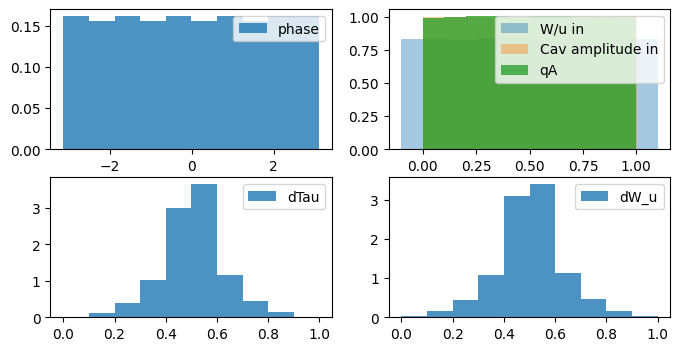

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=2))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 64, 64, 64],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-04-18 17:26
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 6000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL14/model.pt
  - fname_opt: ./WuLEVEL14/optimizer.pt
  - fname_history: ./WuLEVEL14/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:2
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:2
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:2
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:

 Epoch 0067: | Train Loss: 9.85E-08 | Val Loss: 7.40E-08 | lr: 1.92E-05 | 0:35:31.731688
 Epoch 0068: | Train Loss: 9.85E-08 | Val Loss: 8.64E-08 | lr: 1.95E-05 | 0:35:58.097682
 Epoch 0069: | Train Loss: 9.88E-08 | Val Loss: 1.27E-07 | lr: 1.98E-05 | 0:36:23.961305
 Epoch 0070: | Train Loss: 9.86E-08 | Val Loss: 8.71E-08 | lr: 2.01E-05 | 0:36:49.405801
 Epoch 0071: | Train Loss: 9.89E-08 | Val Loss: 1.04E-07 | lr: 2.04E-05 | 0:37:15.855898
 Epoch 0072: | Train Loss: 9.92E-08 | Val Loss: 7.11E-08 | lr: 2.08E-05 | 0:37:41.398359
 Epoch 0073: | Train Loss: 9.94E-08 | Val Loss: 6.82E-08 | lr: 2.11E-05 | 0:38:07.662282
 Epoch 0074: | Train Loss: 9.96E-08 | Val Loss: 6.91E-08 | lr: 2.14E-05 | 0:38:32.987897
 Epoch 0075: | Train Loss: 1.01E-07 | Val Loss: 8.48E-08 | lr: 2.18E-05 | 0:38:59.417923
 Epoch 0076: | Train Loss: 1.01E-07 | Val Loss: 7.87E-08 | lr: 2.21E-05 | 0:39:25.397845
 Epoch 0077: | Train Loss: 1.02E-07 | Val Loss: 7.76E-08 | lr: 2.24E-05 | 0:39:51.183140
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 3.19E-07 | Val Loss: 1.77E-07 | lr: 5.90E-05 | 1:19:56.187044
 Epoch 0161: | Train Loss: 3.22E-07 | Val Loss: 9.51E-08 | lr: 5.94E-05 | 1:20:23.379508
 Epoch 0162: | Train Loss: 3.23E-07 | Val Loss: 1.16E-06 | lr: 5.99E-05 | 1:20:49.532306
 Epoch 0163: | Train Loss: 3.27E-07 | Val Loss: 1.81E-07 | lr: 6.04E-05 | 1:21:15.611778
 Epoch 0164: | Train Loss: 3.29E-07 | Val Loss: 6.14E-08 | lr: 6.09E-05 | 1:21:42.619751
 Epoch 0165: | Train Loss: 3.31E-07 | Val Loss: 5.60E-08 | lr: 6.13E-05 | 1:22:08.464174
 Epoch 0166: | Train Loss: 3.32E-07 | Val Loss: 1.10E-07 | lr: 6.18E-05 | 1:22:41.449467
 Epoch 0167: | Train Loss: 3.37E-07 | Val Loss: 4.17E-07 | lr: 6.23E-05 | 1:23:16.248745
 Epoch 0168: | Train Loss: 3.35E-07 | Val Loss: 3.37E-07 | lr: 6.28E-05 | 1:23:42.533779
 Epoch 0169: | Train Loss: 3.38E-07 | Val Loss: 6.60E-08 | lr: 6.32E-05 | 1:24:08.178599
 Epoch 0170: | Train Loss: 3.40E-07 | Val Loss: 1.46E-07 | lr: 6.37E-05 | 1:24:34.442715
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.20E-07 | Val Loss: 3.12E-07 | lr: 9.46E-05 | 2:03:53.941922
 Epoch 0254: | Train Loss: 3.17E-07 | Val Loss: 1.18E-07 | lr: 9.48E-05 | 2:04:28.030851
 Epoch 0255: | Train Loss: 3.16E-07 | Val Loss: 4.13E-08 | lr: 9.50E-05 | 2:04:59.814097
 Epoch 0256: | Train Loss: 3.16E-07 | Val Loss: 3.52E-07 | lr: 9.52E-05 | 2:05:27.686101
 Epoch 0257: | Train Loss: 3.14E-07 | Val Loss: 1.45E-06 | lr: 9.54E-05 | 2:05:55.479920
 Epoch 0258: | Train Loss: 3.12E-07 | Val Loss: 8.73E-07 | lr: 9.56E-05 | 2:06:26.208323
 Epoch 0259: | Train Loss: 3.12E-07 | Val Loss: 4.55E-08 | lr: 9.58E-05 | 2:07:07.521571
 Epoch 0260: | Train Loss: 3.09E-07 | Val Loss: 8.68E-07 | lr: 9.60E-05 | 2:07:38.577292
 Epoch 0261: | Train Loss: 3.08E-07 | Val Loss: 2.27E-06 | lr: 9.62E-05 | 2:08:04.498884
 Epoch 0262: | Train Loss: 3.07E-07 | Val Loss: 2.95E-07 | lr: 9.64E-05 | 2:08:34.660772
 Epoch 0263: | Train Loss: 3.07E-07 | Val Loss: 3.58E-07 | lr: 9.66E-05 | 2:09:02.400820
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.82E-07 | Val Loss: 1.00E-07 | lr: 1.00E-04 | 2:49:22.829370
 Epoch 0347: | Train Loss: 1.81E-07 | Val Loss: 1.70E-07 | lr: 1.00E-04 | 2:49:53.869405
 Epoch 0348: | Train Loss: 1.80E-07 | Val Loss: 3.12E-08 | lr: 1.00E-04 | 2:50:19.637693
 Epoch 0349: | Train Loss: 1.80E-07 | Val Loss: 7.38E-07 | lr: 1.00E-04 | 2:50:44.940679
 Epoch 0350: | Train Loss: 1.78E-07 | Val Loss: 4.73E-08 | lr: 1.00E-04 | 2:51:10.057553
 Epoch 0351: | Train Loss: 1.76E-07 | Val Loss: 1.34E-07 | lr: 1.00E-04 | 2:51:35.367407
 Epoch 0352: | Train Loss: 1.77E-07 | Val Loss: 9.69E-08 | lr: 1.00E-04 | 2:52:04.729225
 Epoch 0353: | Train Loss: 1.75E-07 | Val Loss: 2.08E-07 | lr: 1.00E-04 | 2:52:43.144682
 Epoch 0354: | Train Loss: 1.74E-07 | Val Loss: 3.15E-07 | lr: 1.00E-04 | 2:53:15.546730
 Epoch 0355: | Train Loss: 1.73E-07 | Val Loss: 2.02E-08 | lr: 1.00E-04 | 2:53:51.773860
 Epoch 0356: | Train Loss: 1.73E-07 | Val Loss: 4.36E-08 | lr: 1.00E-04 | 2:54:22.768246
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.14E-07 | Val Loss: 2.62E-08 | lr: 9.99E-05 | 3:32:58.150983
 Epoch 0440: | Train Loss: 1.14E-07 | Val Loss: 6.66E-08 | lr: 9.99E-05 | 3:33:23.832677
 Epoch 0441: | Train Loss: 1.13E-07 | Val Loss: 1.80E-08 | lr: 9.98E-05 | 3:33:52.238616
 Epoch 0442: | Train Loss: 1.13E-07 | Val Loss: 4.81E-08 | lr: 9.98E-05 | 3:34:22.072276
 Epoch 0443: | Train Loss: 1.13E-07 | Val Loss: 4.16E-07 | lr: 9.98E-05 | 3:34:48.964004
 Epoch 0444: | Train Loss: 1.12E-07 | Val Loss: 1.91E-08 | lr: 9.98E-05 | 3:35:15.459851
 Epoch 0445: | Train Loss: 1.11E-07 | Val Loss: 3.91E-08 | lr: 9.98E-05 | 3:35:46.513421
 Epoch 0446: | Train Loss: 1.11E-07 | Val Loss: 1.46E-07 | lr: 9.98E-05 | 3:36:21.156806
 Epoch 0447: | Train Loss: 1.11E-07 | Val Loss: 1.28E-07 | lr: 9.98E-05 | 3:36:51.598700
 Epoch 0448: | Train Loss: 1.10E-07 | Val Loss: 1.81E-07 | lr: 9.98E-05 | 3:37:23.151943
 Epoch 0449: | Train Loss: 1.09E-07 | Val Loss: 1.69E-07 | lr: 9.98E-05 | 3:37:49.681383
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.79E-08 | Val Loss: 5.84E-08 | lr: 9.96E-05 | 4:17:13.524475
 Epoch 0533: | Train Loss: 7.70E-08 | Val Loss: 7.37E-08 | lr: 9.96E-05 | 4:17:43.383446
 Epoch 0534: | Train Loss: 7.69E-08 | Val Loss: 2.05E-07 | lr: 9.96E-05 | 4:18:16.627934
 Epoch 0535: | Train Loss: 7.65E-08 | Val Loss: 7.81E-08 | lr: 9.96E-05 | 4:18:52.087758
 Epoch 0536: | Train Loss: 7.61E-08 | Val Loss: 1.36E-07 | lr: 9.96E-05 | 4:19:18.750769
 Epoch 0537: | Train Loss: 7.63E-08 | Val Loss: 4.79E-08 | lr: 9.96E-05 | 4:19:45.435500
 Epoch 0538: | Train Loss: 7.56E-08 | Val Loss: 3.73E-08 | lr: 9.96E-05 | 4:20:19.743034
 Epoch 0539: | Train Loss: 7.53E-08 | Val Loss: 3.69E-08 | lr: 9.96E-05 | 4:20:46.881799
 Epoch 0540: | Train Loss: 7.53E-08 | Val Loss: 2.06E-08 | lr: 9.96E-05 | 4:21:17.680043
 Epoch 0541: | Train Loss: 7.46E-08 | Val Loss: 1.81E-08 | lr: 9.96E-05 | 4:21:50.560418
 Epoch 0542: | Train Loss: 7.44E-08 | Val Loss: 2.39E-07 | lr: 9.96E-05 | 4:22:17.407942
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.31E-08 | Val Loss: 1.27E-07 | lr: 9.92E-05 | 4:59:37.234423
 Epoch 0626: | Train Loss: 5.31E-08 | Val Loss: 5.69E-09 | lr: 9.92E-05 | 5:00:02.681214
 Epoch 0627: | Train Loss: 5.27E-08 | Val Loss: 1.11E-07 | lr: 9.92E-05 | 5:00:28.003214
 Epoch 0628: | Train Loss: 5.26E-08 | Val Loss: 1.85E-08 | lr: 9.92E-05 | 5:00:53.607199
 Epoch 0629: | Train Loss: 5.24E-08 | Val Loss: 1.09E-08 | lr: 9.92E-05 | 5:01:19.465609
 Epoch 0630: | Train Loss: 5.21E-08 | Val Loss: 1.87E-08 | lr: 9.92E-05 | 5:01:44.875858
 Epoch 0631: | Train Loss: 5.19E-08 | Val Loss: 1.02E-07 | lr: 9.92E-05 | 5:02:10.212817
 Epoch 0632: | Train Loss: 5.19E-08 | Val Loss: 1.84E-08 | lr: 9.92E-05 | 5:02:35.172105
 Epoch 0633: | Train Loss: 5.15E-08 | Val Loss: 3.24E-08 | lr: 9.92E-05 | 5:03:00.592137
 Epoch 0634: | Train Loss: 5.14E-08 | Val Loss: 9.97E-09 | lr: 9.92E-05 | 5:03:25.612062
 Epoch 0635: | Train Loss: 5.12E-08 | Val Loss: 1.13E-08 | lr: 9.92E-05 | 5:03:55.058548
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.77E-08 | Val Loss: 9.87E-08 | lr: 9.87E-05 | 5:42:30.974959
 Epoch 0719: | Train Loss: 3.76E-08 | Val Loss: 6.90E-09 | lr: 9.87E-05 | 5:43:02.413605
 Epoch 0720: | Train Loss: 3.74E-08 | Val Loss: 2.99E-08 | lr: 9.87E-05 | 5:43:29.780071
 Epoch 0721: | Train Loss: 3.74E-08 | Val Loss: 6.29E-09 | lr: 9.87E-05 | 5:43:56.050478
 Epoch 0722: | Train Loss: 3.72E-08 | Val Loss: 5.42E-09 | lr: 9.87E-05 | 5:44:20.968115
 Epoch 0723: | Train Loss: 3.70E-08 | Val Loss: 1.37E-08 | lr: 9.86E-05 | 5:44:47.762331
 Epoch 0724: | Train Loss: 3.69E-08 | Val Loss: 3.37E-08 | lr: 9.86E-05 | 5:45:17.774126
 Epoch 0725: | Train Loss: 3.68E-08 | Val Loss: 1.57E-07 | lr: 9.86E-05 | 5:45:44.283695
 Epoch 0726: | Train Loss: 3.66E-08 | Val Loss: 8.41E-09 | lr: 9.86E-05 | 5:46:10.353216
 Epoch 0727: | Train Loss: 3.65E-08 | Val Loss: 3.82E-08 | lr: 9.86E-05 | 5:46:36.016437
 Epoch 0728: | Train Loss: 3.65E-08 | Val Loss: 2.52E-08 | lr: 9.86E-05 | 5:47:01.258343
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 2.81E-08 | Val Loss: 4.42E-09 | lr: 9.80E-05 | 6:25:37.932284
 Epoch 0812: | Train Loss: 2.78E-08 | Val Loss: 7.17E-09 | lr: 9.80E-05 | 6:26:03.620779
 Epoch 0813: | Train Loss: 2.78E-08 | Val Loss: 2.08E-08 | lr: 9.80E-05 | 6:26:30.092831
 Epoch 0814: | Train Loss: 2.78E-08 | Val Loss: 5.93E-08 | lr: 9.80E-05 | 6:26:56.271295
 Epoch 0815: | Train Loss: 2.77E-08 | Val Loss: 3.28E-09 | lr: 9.80E-05 | 6:27:22.817454
 Epoch 0816: | Train Loss: 2.75E-08 | Val Loss: 1.72E-08 | lr: 9.80E-05 | 6:27:48.370736
 Epoch 0817: | Train Loss: 2.76E-08 | Val Loss: 1.00E-08 | lr: 9.80E-05 | 6:28:17.182078
 Epoch 0818: | Train Loss: 2.74E-08 | Val Loss: 4.19E-08 | lr: 9.80E-05 | 6:28:45.107549
 Epoch 0819: | Train Loss: 2.74E-08 | Val Loss: 8.64E-09 | lr: 9.80E-05 | 6:29:10.444386
 Epoch 0820: | Train Loss: 2.73E-08 | Val Loss: 9.37E-09 | lr: 9.80E-05 | 6:29:35.612866
 Epoch 0821: | Train Loss: 2.74E-08 | Val Loss: 4.66E-09 | lr: 9.80E-05 | 6:30:01.213830
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.20E-08 | Val Loss: 3.31E-09 | lr: 9.73E-05 | 7:09:51.380431
 Epoch 0905: | Train Loss: 2.19E-08 | Val Loss: 5.88E-09 | lr: 9.72E-05 | 7:10:25.604420
 Epoch 0906: | Train Loss: 2.17E-08 | Val Loss: 3.12E-09 | lr: 9.72E-05 | 7:10:52.976480
 Epoch 0907: | Train Loss: 2.18E-08 | Val Loss: 4.10E-09 | lr: 9.72E-05 | 7:11:21.015217
 Epoch 0908: | Train Loss: 2.17E-08 | Val Loss: 6.57E-09 | lr: 9.72E-05 | 7:11:51.202119
 Epoch 0909: | Train Loss: 2.16E-08 | Val Loss: 8.45E-08 | lr: 9.72E-05 | 7:12:21.537344
 Epoch 0910: | Train Loss: 2.16E-08 | Val Loss: 1.84E-08 | lr: 9.72E-05 | 7:12:47.343204
 Epoch 0911: | Train Loss: 2.15E-08 | Val Loss: 3.91E-09 | lr: 9.72E-05 | 7:13:12.695506
 Epoch 0912: | Train Loss: 2.14E-08 | Val Loss: 4.48E-09 | lr: 9.72E-05 | 7:13:45.546339
 Epoch 0913: | Train Loss: 2.14E-08 | Val Loss: 6.43E-09 | lr: 9.72E-05 | 7:14:10.993634
 Epoch 0914: | Train Loss: 2.14E-08 | Val Loss: 1.69E-08 | lr: 9.72E-05 | 7:14:44.130046
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 1.81E-08 | Val Loss: 1.98E-08 | lr: 9.64E-05 | 7:54:25.251984
 Epoch 0998: | Train Loss: 1.78E-08 | Val Loss: 5.19E-08 | lr: 9.63E-05 | 7:54:53.152754
 Epoch 0999: | Train Loss: 1.79E-08 | Val Loss: 2.61E-09 | lr: 9.63E-05 | 7:55:25.970024
 Epoch 1000: | Train Loss: 1.78E-08 | Val Loss: 1.43E-08 | lr: 9.63E-05 | 7:56:04.706590
 Epoch 1001: | Train Loss: 1.77E-08 | Val Loss: 8.70E-09 | lr: 9.63E-05 | 7:56:42.184796
 Epoch 1002: | Train Loss: 1.78E-08 | Val Loss: 3.26E-09 | lr: 9.63E-05 | 7:57:07.911242
 Epoch 1003: | Train Loss: 1.77E-08 | Val Loss: 1.83E-08 | lr: 9.63E-05 | 7:57:33.990469
 Epoch 1004: | Train Loss: 1.77E-08 | Val Loss: 2.52E-08 | lr: 9.63E-05 | 7:57:59.704542
 Epoch 1005: | Train Loss: 1.77E-08 | Val Loss: 2.75E-09 | lr: 9.63E-05 | 7:58:26.488691
 Epoch 1006: | Train Loss: 1.76E-08 | Val Loss: 5.50E-09 | lr: 9.63E-05 | 7:58:52.021706
 Epoch 1007: | Train Loss: 1.76E-08 | Val Loss: 2.94E-08 | lr: 9.63E-05 | 7:59:17.104266
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.52E-08 | Val Loss: 2.96E-09 | lr: 9.53E-05 | 8:39:51.945643
 Epoch 1091: | Train Loss: 1.52E-08 | Val Loss: 8.56E-09 | lr: 9.53E-05 | 8:40:18.400561
 Epoch 1092: | Train Loss: 1.51E-08 | Val Loss: 3.25E-08 | lr: 9.53E-05 | 8:40:47.663673
 Epoch 1093: | Train Loss: 1.51E-08 | Val Loss: 7.97E-09 | lr: 9.53E-05 | 8:41:15.582334
 Epoch 1094: | Train Loss: 1.51E-08 | Val Loss: 5.48E-09 | lr: 9.53E-05 | 8:41:42.854014
 Epoch 1095: | Train Loss: 1.50E-08 | Val Loss: 4.02E-09 | lr: 9.53E-05 | 8:42:12.104762
 Epoch 1096: | Train Loss: 1.51E-08 | Val Loss: 4.76E-09 | lr: 9.53E-05 | 8:42:43.960051
 Epoch 1097: | Train Loss: 1.50E-08 | Val Loss: 3.01E-09 | lr: 9.53E-05 | 8:43:17.800510
 Epoch 1098: | Train Loss: 1.50E-08 | Val Loss: 3.51E-08 | lr: 9.52E-05 | 8:43:44.312114
 Epoch 1099: | Train Loss: 1.50E-08 | Val Loss: 3.16E-09 | lr: 9.52E-05 | 8:44:11.957992
 Epoch 1100: | Train Loss: 1.50E-08 | Val Loss: 2.36E-09 | lr: 9.52E-05 | 8:44:41.395488
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.32E-08 | Val Loss: 2.38E-09 | lr: 9.42E-05 | 9:25:38.268512
 Epoch 1184: | Train Loss: 1.32E-08 | Val Loss: 4.11E-09 | lr: 9.42E-05 | 9:26:06.684814
 Epoch 1185: | Train Loss: 1.32E-08 | Val Loss: 2.32E-09 | lr: 9.42E-05 | 9:26:33.339876
 Epoch 1186: | Train Loss: 1.32E-08 | Val Loss: 5.44E-08 | lr: 9.42E-05 | 9:26:59.364607
 Epoch 1187: | Train Loss: 1.30E-08 | Val Loss: 1.64E-08 | lr: 9.41E-05 | 9:27:26.374713
 Epoch 1188: | Train Loss: 1.31E-08 | Val Loss: 2.81E-09 | lr: 9.41E-05 | 9:27:54.140489
 Epoch 1189: | Train Loss: 1.31E-08 | Val Loss: 8.45E-09 | lr: 9.41E-05 | 9:28:21.076218
 Epoch 1190: | Train Loss: 1.31E-08 | Val Loss: 7.90E-08 | lr: 9.41E-05 | 9:28:52.271603
 Epoch 1191: | Train Loss: 1.30E-08 | Val Loss: 5.42E-09 | lr: 9.41E-05 | 9:29:21.763160
 Epoch 1192: | Train Loss: 1.30E-08 | Val Loss: 9.71E-09 | lr: 9.41E-05 | 9:29:50.937284
 Epoch 1193: | Train Loss: 1.30E-08 | Val Loss: 4.22E-09 | lr: 9.41E-05 | 9:30:26.520383
 Epoch 1194: | Train 

 Epoch 1275: | Train Loss: 1.16E-08 | Val Loss: 4.12E-08 | lr: 9.30E-05 | 10:12:09.258994
 Epoch 1276: | Train Loss: 1.17E-08 | Val Loss: 1.54E-08 | lr: 9.29E-05 | 10:12:35.563657
 Epoch 1277: | Train Loss: 1.17E-08 | Val Loss: 1.47E-08 | lr: 9.29E-05 | 10:13:09.683003
 Epoch 1278: | Train Loss: 1.16E-08 | Val Loss: 1.02E-08 | lr: 9.29E-05 | 10:13:38.599276
 Epoch 1279: | Train Loss: 1.16E-08 | Val Loss: 6.68E-09 | lr: 9.29E-05 | 10:14:05.738576
 Epoch 1280: | Train Loss: 1.16E-08 | Val Loss: 4.76E-09 | lr: 9.29E-05 | 10:14:35.714252
 Epoch 1281: | Train Loss: 1.16E-08 | Val Loss: 3.22E-09 | lr: 9.29E-05 | 10:15:10.972986
 Epoch 1282: | Train Loss: 1.16E-08 | Val Loss: 8.66E-09 | lr: 9.29E-05 | 10:15:39.504864
 Epoch 1283: | Train Loss: 1.16E-08 | Val Loss: 1.60E-08 | lr: 9.28E-05 | 10:16:11.384466
 Epoch 1284: | Train Loss: 1.15E-08 | Val Loss: 3.41E-08 | lr: 9.28E-05 | 10:16:41.279873
 Epoch 1285: | Train Loss: 1.15E-08 | Val Loss: 2.15E-09 | lr: 9.28E-05 | 10:17:12.779713
 Epoch 128

 Epoch 1367: | Train Loss: 1.04E-08 | Val Loss: 6.13E-09 | lr: 9.16E-05 | 10:58:12.165296
 Epoch 1368: | Train Loss: 1.04E-08 | Val Loss: 6.14E-09 | lr: 9.16E-05 | 10:58:43.728294
 Epoch 1369: | Train Loss: 1.04E-08 | Val Loss: 5.14E-09 | lr: 9.16E-05 | 10:59:13.243457
 Epoch 1370: | Train Loss: 1.04E-08 | Val Loss: 3.37E-08 | lr: 9.16E-05 | 10:59:38.228039
 Epoch 1371: | Train Loss: 1.03E-08 | Val Loss: 2.73E-09 | lr: 9.15E-05 | 11:00:03.247101
 Epoch 1372: | Train Loss: 1.03E-08 | Val Loss: 4.48E-09 | lr: 9.15E-05 | 11:00:28.457015
 Epoch 1373: | Train Loss: 1.03E-08 | Val Loss: 2.49E-09 | lr: 9.15E-05 | 11:00:54.807018
 Epoch 1374: | Train Loss: 1.03E-08 | Val Loss: 2.85E-08 | lr: 9.15E-05 | 11:01:26.673611
 Epoch 1375: | Train Loss: 1.03E-08 | Val Loss: 1.87E-09 | lr: 9.15E-05 | 11:01:53.018861
 Epoch 1376: | Train Loss: 1.03E-08 | Val Loss: 1.07E-08 | lr: 9.15E-05 | 11:02:18.782040
 Epoch 1377: | Train Loss: 1.03E-08 | Val Loss: 2.91E-09 | lr: 9.14E-05 | 11:02:52.455441
 Epoch 137

 Epoch 1459: | Train Loss: 9.29E-09 | Val Loss: 5.97E-08 | lr: 9.01E-05 | 11:43:33.753867
 Epoch 1460: | Train Loss: 9.31E-09 | Val Loss: 5.86E-09 | lr: 9.01E-05 | 11:44:00.991288
 Epoch 1461: | Train Loss: 9.30E-09 | Val Loss: 6.41E-09 | lr: 9.01E-05 | 11:44:39.972026
 Epoch 1462: | Train Loss: 9.34E-09 | Val Loss: 1.18E-07 | lr: 9.01E-05 | 11:45:12.452587
 Epoch 1463: | Train Loss: 9.31E-09 | Val Loss: 1.60E-09 | lr: 9.01E-05 | 11:45:43.236782
 Epoch 1464: | Train Loss: 9.27E-09 | Val Loss: 1.80E-09 | lr: 9.01E-05 | 11:46:09.275731
 Epoch 1465: | Train Loss: 9.22E-09 | Val Loss: 1.12E-08 | lr: 9.00E-05 | 11:46:34.823534
 Epoch 1466: | Train Loss: 9.27E-09 | Val Loss: 5.95E-09 | lr: 9.00E-05 | 11:47:00.172565
 Epoch 1467: | Train Loss: 9.21E-09 | Val Loss: 2.08E-09 | lr: 9.00E-05 | 11:47:30.479664
 Epoch 1468: | Train Loss: 9.25E-09 | Val Loss: 2.56E-08 | lr: 9.00E-05 | 11:47:56.656875
 Epoch 1469: | Train Loss: 9.22E-09 | Val Loss: 2.57E-09 | lr: 9.00E-05 | 11:48:22.517164
 Epoch 147

 Epoch 1551: | Train Loss: 8.40E-09 | Val Loss: 5.46E-09 | lr: 8.86E-05 | 12:26:26.352865
 Epoch 1552: | Train Loss: 8.41E-09 | Val Loss: 5.57E-09 | lr: 8.86E-05 | 12:26:51.700895
 Epoch 1553: | Train Loss: 8.34E-09 | Val Loss: 2.56E-08 | lr: 8.85E-05 | 12:27:24.335324
 Epoch 1554: | Train Loss: 8.39E-09 | Val Loss: 1.12E-08 | lr: 8.85E-05 | 12:27:50.746292
 Epoch 1555: | Train Loss: 8.40E-09 | Val Loss: 2.26E-09 | lr: 8.85E-05 | 12:28:16.080589
 Epoch 1556: | Train Loss: 8.32E-09 | Val Loss: 6.96E-09 | lr: 8.85E-05 | 12:28:41.753443
 Epoch 1557: | Train Loss: 8.36E-09 | Val Loss: 2.36E-09 | lr: 8.85E-05 | 12:29:07.158598
 Epoch 1558: | Train Loss: 8.34E-09 | Val Loss: 1.27E-08 | lr: 8.85E-05 | 12:29:32.757395
 Epoch 1559: | Train Loss: 8.31E-09 | Val Loss: 3.42E-09 | lr: 8.84E-05 | 12:29:58.302637
 Epoch 1560: | Train Loss: 8.31E-09 | Val Loss: 8.09E-08 | lr: 8.84E-05 | 12:30:23.665797
 Epoch 1561: | Train Loss: 8.30E-09 | Val Loss: 4.19E-08 | lr: 8.84E-05 | 12:30:49.025239
 Epoch 156

 Epoch 1643: | Train Loss: 7.58E-09 | Val Loss: 2.10E-09 | lr: 8.69E-05 | 13:09:03.802803
 Epoch 1644: | Train Loss: 7.55E-09 | Val Loss: 1.62E-08 | lr: 8.69E-05 | 13:09:35.547582
 Epoch 1645: | Train Loss: 7.55E-09 | Val Loss: 7.56E-09 | lr: 8.69E-05 | 13:10:12.077688
 Epoch 1646: | Train Loss: 7.53E-09 | Val Loss: 2.47E-09 | lr: 8.69E-05 | 13:10:43.380297
 Epoch 1647: | Train Loss: 7.55E-09 | Val Loss: 9.83E-09 | lr: 8.68E-05 | 13:11:21.155987
 Epoch 1648: | Train Loss: 7.52E-09 | Val Loss: 2.22E-09 | lr: 8.68E-05 | 13:11:47.135312
 Epoch 1649: | Train Loss: 7.50E-09 | Val Loss: 2.30E-09 | lr: 8.68E-05 | 13:12:16.362948
 Epoch 1650: | Train Loss: 7.52E-09 | Val Loss: 3.05E-09 | lr: 8.68E-05 | 13:12:49.645647
 Epoch 1651: | Train Loss: 7.48E-09 | Val Loss: 2.00E-09 | lr: 8.68E-05 | 13:13:20.523060
 Epoch 1652: | Train Loss: 7.50E-09 | Val Loss: 5.25E-09 | lr: 8.67E-05 | 13:13:50.234988
 Epoch 1653: | Train Loss: 7.49E-09 | Val Loss: 3.61E-08 | lr: 8.67E-05 | 13:14:16.878590
 Epoch 165

 Epoch 1735: | Train Loss: 6.82E-09 | Val Loss: 1.77E-09 | lr: 8.52E-05 | 13:53:35.392270
 Epoch 1736: | Train Loss: 6.82E-09 | Val Loss: 8.68E-09 | lr: 8.51E-05 | 13:54:01.304551
 Epoch 1737: | Train Loss: 6.77E-09 | Val Loss: 2.87E-09 | lr: 8.51E-05 | 13:54:26.999157
 Epoch 1738: | Train Loss: 6.81E-09 | Val Loss: 6.70E-09 | lr: 8.51E-05 | 13:54:54.983585
 Epoch 1739: | Train Loss: 6.80E-09 | Val Loss: 3.45E-09 | lr: 8.51E-05 | 13:55:20.760532
 Epoch 1740: | Train Loss: 6.77E-09 | Val Loss: 1.04E-08 | lr: 8.51E-05 | 13:55:46.233898
 Epoch 1741: | Train Loss: 6.78E-09 | Val Loss: 2.17E-08 | lr: 8.50E-05 | 13:56:11.043176
 Epoch 1742: | Train Loss: 6.75E-09 | Val Loss: 2.60E-09 | lr: 8.50E-05 | 13:56:35.772243
 Epoch 1743: | Train Loss: 6.75E-09 | Val Loss: 1.05E-08 | lr: 8.50E-05 | 13:57:00.550730
 Epoch 1744: | Train Loss: 6.74E-09 | Val Loss: 3.76E-09 | lr: 8.50E-05 | 13:57:26.803403
 Epoch 1745: | Train Loss: 6.73E-09 | Val Loss: 5.23E-09 | lr: 8.50E-05 | 13:58:00.402230
 Epoch 174

 Epoch 1827: | Train Loss: 6.08E-09 | Val Loss: 1.28E-09 | lr: 8.33E-05 | 14:37:30.638077
 Epoch 1828: | Train Loss: 6.12E-09 | Val Loss: 9.39E-09 | lr: 8.33E-05 | 14:37:57.761917
 Epoch 1829: | Train Loss: 6.11E-09 | Val Loss: 3.50E-09 | lr: 8.33E-05 | 14:38:24.681440
 Epoch 1830: | Train Loss: 6.09E-09 | Val Loss: 2.73E-09 | lr: 8.33E-05 | 14:38:50.671607
 Epoch 1831: | Train Loss: 6.09E-09 | Val Loss: 3.71E-09 | lr: 8.32E-05 | 14:39:18.419973
 Epoch 1832: | Train Loss: 6.07E-09 | Val Loss: 3.09E-09 | lr: 8.32E-05 | 14:39:51.173702
 Epoch 1833: | Train Loss: 6.07E-09 | Val Loss: 2.77E-09 | lr: 8.32E-05 | 14:40:21.418062
 Epoch 1834: | Train Loss: 6.09E-09 | Val Loss: 4.42E-09 | lr: 8.32E-05 | 14:40:53.297786
 Epoch 1835: | Train Loss: 6.09E-09 | Val Loss: 5.39E-09 | lr: 8.31E-05 | 14:41:25.527177
 Epoch 1836: | Train Loss: 6.04E-09 | Val Loss: 1.68E-08 | lr: 8.31E-05 | 14:41:51.811691
 Epoch 1837: | Train Loss: 6.07E-09 | Val Loss: 2.78E-09 | lr: 8.31E-05 | 14:42:20.530224
 Epoch 183

 Epoch 1919: | Train Loss: 5.51E-09 | Val Loss: 1.32E-09 | lr: 8.14E-05 | 15:19:25.608710
 Epoch 1920: | Train Loss: 5.47E-09 | Val Loss: 1.81E-09 | lr: 8.14E-05 | 15:19:59.767172
 Epoch 1921: | Train Loss: 5.49E-09 | Val Loss: 3.27E-09 | lr: 8.13E-05 | 15:20:33.314889
 Epoch 1922: | Train Loss: 5.46E-09 | Val Loss: 1.45E-08 | lr: 8.13E-05 | 15:21:00.307627
 Epoch 1923: | Train Loss: 5.45E-09 | Val Loss: 4.67E-09 | lr: 8.13E-05 | 15:21:28.434029
 Epoch 1924: | Train Loss: 5.48E-09 | Val Loss: 1.03E-08 | lr: 8.13E-05 | 15:21:55.881236
 Epoch 1925: | Train Loss: 5.44E-09 | Val Loss: 2.41E-09 | lr: 8.13E-05 | 15:22:26.298294
 Epoch 1926: | Train Loss: 5.43E-09 | Val Loss: 8.66E-09 | lr: 8.12E-05 | 15:22:54.444111
 Epoch 1927: | Train Loss: 5.42E-09 | Val Loss: 3.67E-09 | lr: 8.12E-05 | 15:23:27.440220
 Epoch 1928: | Train Loss: 5.43E-09 | Val Loss: 1.73E-09 | lr: 8.12E-05 | 15:23:59.111728
 Epoch 1929: | Train Loss: 5.42E-09 | Val Loss: 1.46E-09 | lr: 8.12E-05 | 15:24:32.403527
 Epoch 193

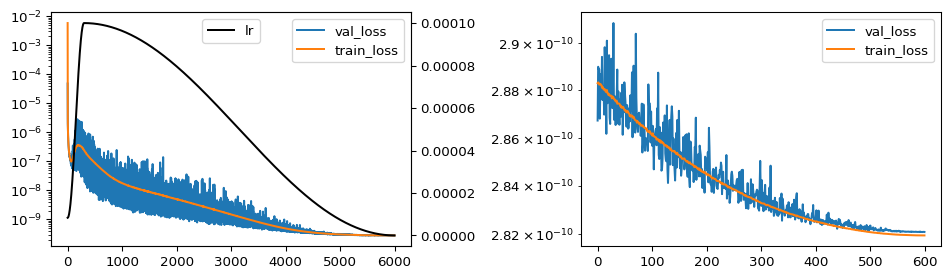

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(2.819346719882302e-10, 2.820760696990031e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 133.89559304341674 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 98.88391958549619 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

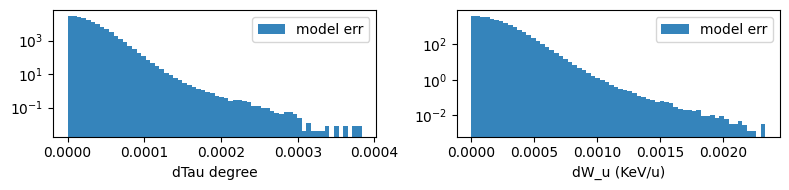

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)